## 📘 Notebook 1: Data Preparation & Analysis

**Funcionalidades:**
1. Carrega dataset da estrutura de pastas (data/odir5k/)
2. Data Loader otimizado para a nova estrutura
3. Data Augmentation para treino
4. Visualizações e estatísticas

In [14]:
##%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [15]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path

# Pega no caminho da pasta onde o notebook está (ex: .../notebooks)
CURRENT_DIR = os.getcwd()

# Define o PROJECT_ROOT como sendo a pasta "mãe" (odir-project)
PROJECT_ROOT = os.path.dirname(CURRENT_DIR) 

# Agora o DATASET_ROOT apontará corretamente para odir-project/data/odir5k
DATASET_ROOT = os.path.join(PROJECT_ROOT, "data", "odir5k")

print(f"Caminho do Notebook: {CURRENT_DIR}")
print(f"Raiz do Projeto: {PROJECT_ROOT}")
print(f"Caminho do Dataset: {DATASET_ROOT}")

# Verificar se agora o caminho está correto
if os.path.exists(DATASET_ROOT):
    print("✅ Sucesso: Pasta de dados encontrada!")
else:
    print("❌ Erro: A pasta ainda não foi encontrada. Verifica se o nome é 'odir5k' ou 'ODIR-5K'.")

Caminho do Notebook: /home/carolina-silva/UA/MEI/1ºANO/1SEMESTRE/FAA/Projeto1/projects_faa/project2/odir-project/notebooks
Raiz do Projeto: /home/carolina-silva/UA/MEI/1ºANO/1SEMESTRE/FAA/Projeto1/projects_faa/project2/odir-project
Caminho do Dataset: /home/carolina-silva/UA/MEI/1ºANO/1SEMESTRE/FAA/Projeto1/projects_faa/project2/odir-project/data/odir5k
✅ Sucesso: Pasta de dados encontrada!


In [16]:
class ODIRDataset(Dataset):
    """Dataset ODIR-5K usando estrutura de pastas"""
    
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(DATASET_ROOT, split)
        
        # Carregar metadados
        metadata_path = os.path.join(self.img_dir, f"{split}_metadata.csv")
        self.data = pd.read_csv(metadata_path)
        self.disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
        self.image_files = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        
        print(f"  📂 {split}: {len(self.data)} pacientes, {len(self.image_files)} imagens")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient_id = str(row['ID'])
        
        img_path = None
        for side in ['left', 'right']:
            img_name = f"{patient_id}_{side}.jpg"
            full_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(full_path):
                img_path = full_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Imagem não encontrada para ID {patient_id}")
        
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor([row[col] for col in self.disease_cols], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels, patient_id

In [17]:
def get_train_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_test_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [18]:
def visualize_augmentation(dataset, save_path='results/augmentation_examples.png', num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Data Augmentation - Exemplos', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        img, label, patient_id = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original ID: {patient_id}', fontsize=10)
        
        img_aug, _, _ = dataset[i]
        img_aug = img_aug.permute(1, 2, 0).numpy()
        img_aug = img_aug * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_aug = np.clip(img_aug, 0, 1)
        
        axes[1, i].imshow(img_aug)
        axes[1, i].axis('off')
        axes[1, i].set_title('Augmented', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show() # Garante que aparece no Notebook
    print(f"  ✅ Exemplos guardados em: {save_path}")

def plot_dataset_statistics(save_path='results/dataset_statistics.png'):
    train_data = pd.read_csv(os.path.join(DATASET_ROOT, 'train', 'train_metadata.csv'))
    disease_names = {'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 'C': 'Cataract', 
                     'A': 'AMD', 'H': 'Hypertension', 'M': 'Myopia', 'O': 'Other'}
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Dataset Statistics - Training Set', fontsize=16, fontweight='bold')
    
    # 1. Distribuição de doenças
    disease_counts = train_data[list(disease_names.keys())].sum().sort_values(ascending=False)
    axes[0, 0].bar(range(len(disease_counts)), disease_counts.values, color='steelblue')
    axes[0, 0].set_xticks(range(len(disease_counts)))
    axes[0, 0].set_xticklabels([disease_names[k] for k in disease_counts.index], rotation=45, ha='right')
    axes[0, 0].set_title('Distribuição de Doenças')
    
    # 2. Distribuição de idade
    axes[0, 1].hist(train_data['Patient Age'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribuição de Idade')
    
    # 3. Distribuição por sexo
    sex_counts = train_data['Patient Sex'].value_counts()
    axes[1, 0].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightpink'], startangle=90)
    axes[1, 0].set_title('Distribuição por Sexo')
    
    # 4. Doenças por paciente
    diseases_per_patient = train_data[list(disease_names.keys())].sum(axis=1)
    axes[1, 1].hist(diseases_per_patient, bins=range(0, 9), color='mediumseagreen', edgecolor='black', alpha=0.7, align='left')
    axes[1, 1].set_title('Doenças por Paciente')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show() # Garante que aparece no Notebook
    print(f"  ✅ Estatísticas guardadas em: {save_path}")

  📂 train: 4474 pacientes, 5732 imagens
  📂 val: 959 pacientes, 1728 imagens
  📂 test: 959 pacientes, 1748 imagens


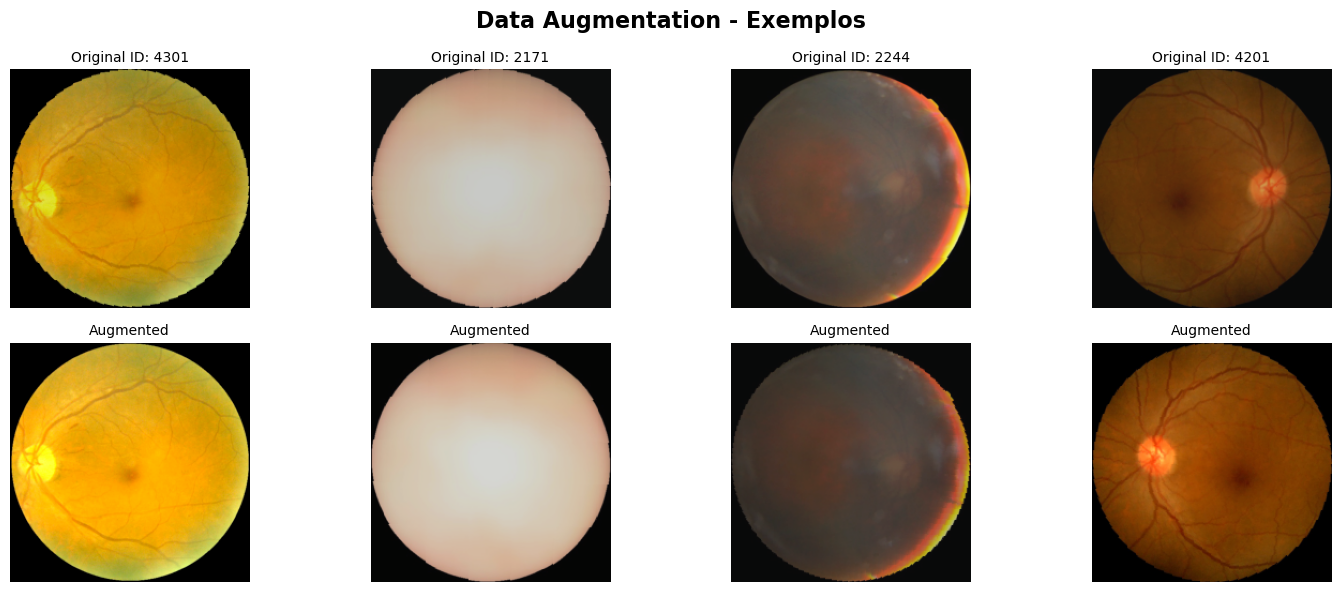

  ✅ Exemplos guardados em: results/augmentation_examples.png


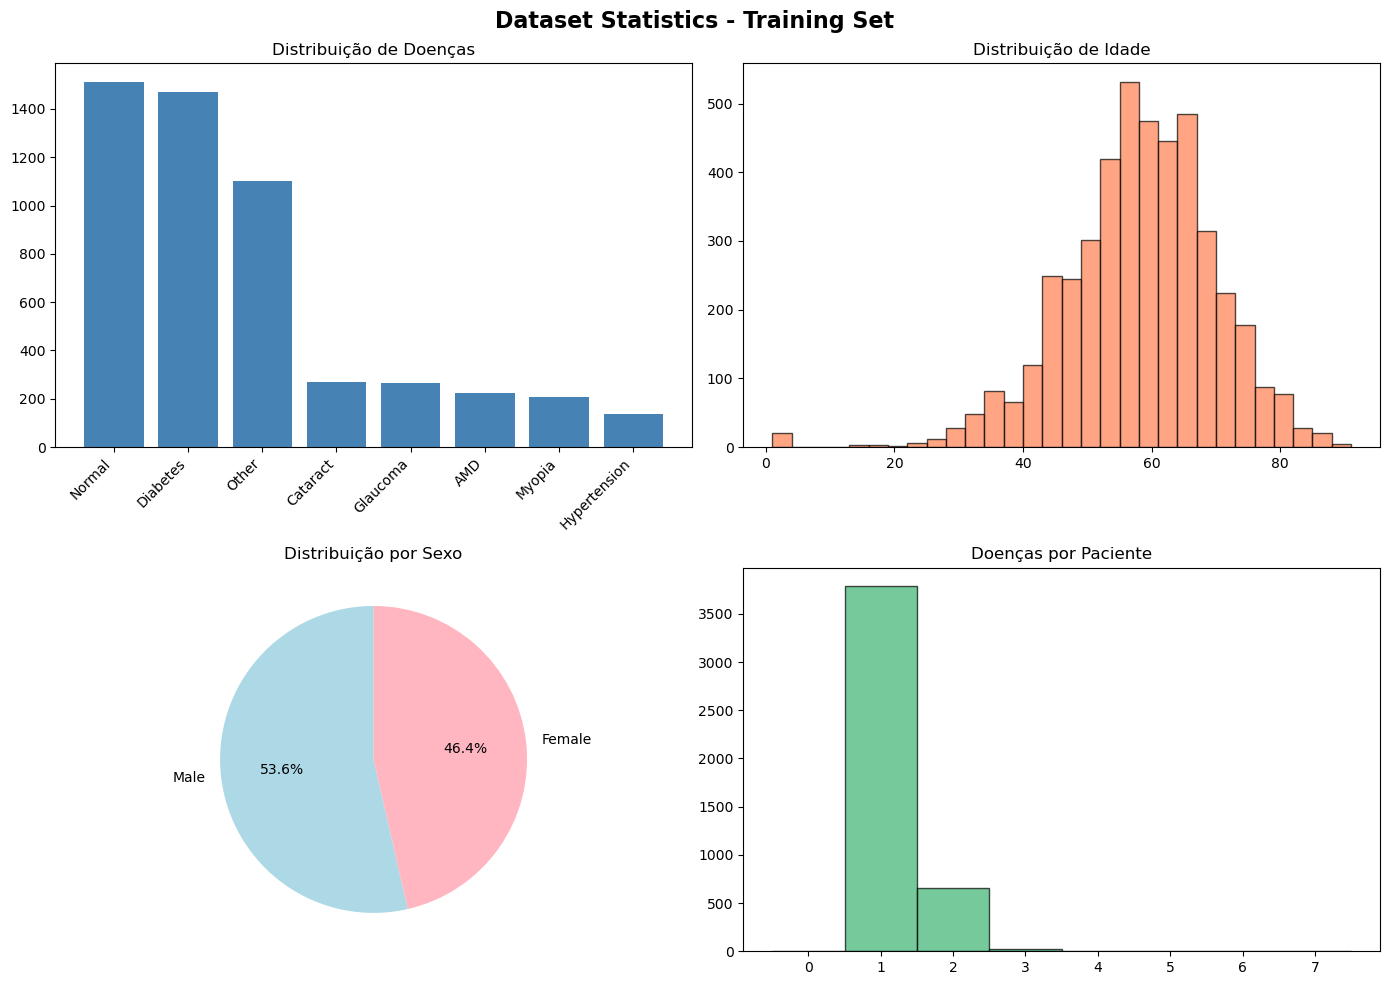

  ✅ Estatísticas guardadas em: results/dataset_statistics.png

✅ Resumo: Treino: 4474 | Val: 959 | Teste: 959


In [19]:
# --- Verificação de Segurança ---
if not os.path.exists(DATASET_ROOT):
    print(f"❌ ERRO: Dataset não encontrado em {DATASET_ROOT}")
else:
    # 1. Criar Datasets
    train_dataset = ODIRDataset('train', transform=get_train_transform())
    val_dataset = ODIRDataset('val', transform=get_val_test_transform())
    test_dataset = ODIRDataset('test', transform=get_val_test_transform())

    # 2. Criar Loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # 3. Visualizar e Salvar
    visualize_augmentation(train_dataset)
    plot_dataset_statistics()

    print("\n✅ Resumo: Treino:", len(train_dataset), "| Val:", len(val_dataset), "| Teste:", len(test_dataset))